In [198]:
import numpy as np
from numpy import cos as c
from numpy import sin as s

from scipy import integrate
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.optimize import broyden1
from scipy.stats import gamma
from scipy.stats import scoreatpercentile
# from scipy.stats import lognorm
from scipy.stats import maxwell
from scipy.fftpack import fft, ifft
# from common_dists import PERT

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("paper.mplstyle")

In [2]:
mc_arr   = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
nuZens   = mc_arr["nuZen"]
nuAzs    = mc_arr["nuAz"]
recoZens = mc_arr["recoZen"]
recoAzs  = mc_arr["recoAz"]
log10nuE = np.log10(mc_arr["nuE"])

In [3]:
log10e_edges = np.linspace(2,6,41)
nue = np.power(10, log10e_edges)
nue_cents = (nue[:-1]+nue[1:])/2.

delta_psi_edges = np.logspace(-4,2,101)
delta_psi_centers = (delta_psi_edges[1:]+delta_psi_edges[:-1])/2.
delta_psi_widths  = delta_psi_edges[1:]-delta_psi_edges[:-1]

In [4]:
def opening_angle(zen1, az1, zen2, az2):
    return np.arccos(np.sin(zen1)*np.sin(zen2)*np.cos(az1-az2)+np.cos(zen1)*np.cos(zen2))

In [5]:
def rotate_coords(nu_az, nu_zen, gen_az, gen_zen):
    reco_x   =  c(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) - s(nu_az)*s(gen_az)*s(gen_zen) + c(nu_az)*s(nu_zen)*c(gen_zen)
    reco_y   =  s(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_az)*s(gen_az)*s(gen_zen) + s(nu_az)*s(nu_zen)*c(gen_zen)
    reco_z   = -s(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_zen)*c(gen_zen)
    reco_az  = np.arctan(reco_y / reco_x)+np.pi
    reco_zen = np.arccos(reco_z)
    return reco_az, reco_zen

In [6]:
def get_zeros_outta_there(arr):
    arr     = np.asarray(arr)
    max_i   = np.argmax(arr)
    zeros_i = np.argwhere(arr==0)
    arr1    = np.delete(zeros_i, np.argwhere(zeros_i>max_i))
    arr2    = np.delete(zeros_i, np.argwhere(zeros_i<max_i))
    return max(arr1)+1, min(arr2)

In [7]:
def maxwell(x, a):
    return 4. / (np.sqrt(np.pi)*a**3)*x**2*np.exp(-x**2)

In [199]:
opening_angles = np.degrees(opening_angle(nuZens, nuAzs, recoZens, recoAzs))

In [208]:
print(zen_edges)

[3.14159265 2.96705973 2.7925268  2.61799388 2.44346095 2.26892803
 2.0943951  1.91986218 1.74532925 1.57079633 1.39933989]


1.23188199936e-08


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


1.29472293299e-08
7.80110790273e-09
1.2584561799e-08
1.15540893234e-08
1.02599567324e-08
6.37601728292e-09
1.08332710872e-08
1.083249066e-08
1.42474557899e-08


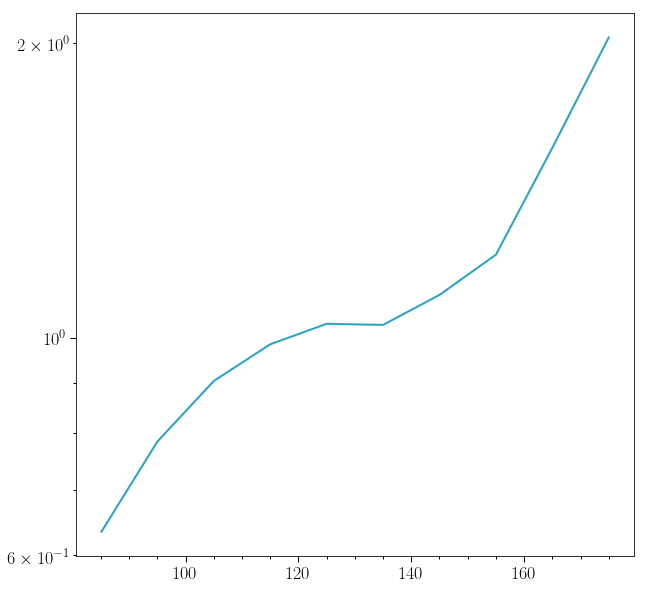

In [209]:
zen_edges  = np.append(np.min(nuZens),np.radians(np.linspace(90,180,10)))
zen_cents  = (zen_edges[1:]+zen_edges[:-1])/2.
zen_widths = zen_edges[1:]+zen_edges[:-1]

h = np.histogram2d(nuZens, opening_angles, bins=[zen_edges, delta_psi_edges])
med_error = []

for j, arr in enumerate(h[0]):
    i0, i1 = get_zeros_outta_there(arr)
    arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
    delta_psi_centers_good = delta_psi_centers[i0:i1]
    
    dn_dtheta = arr / delta_psi_widths
    f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-3)
    
    def dn_dtheta_interp(x):
        logx = f(np.log10(x))
        return np.power(10, logx)
    
    def cdf(y, norm):

        i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
        return i[0] / norm

    i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])
    print(i[1] / i[0])
    norm = i[0]
    norms.append(norm)
    
    xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
    yy = [cdf(x, norm) for x in xx]
    spline = dn_dtheta_interp(xx)
    
    p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
    a      = np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p)
    median = np.median(a)
    med_error.append(median)
    
plt.plot(np.degrees(zen_cents), med_error)
plt.semilogy()
plt.show()

0
1.25977603145e-08
1.31394603318e-08
1.18066046576e-08
1.13956608601e-08
1.47848156744e-08
1.30699857844e-08
1.15158385507e-08
1.29001984004e-08
1.19807782753e-08
1.3429800431e-08
1.37316656965e-08
1.24028891684e-08
1.30419482249e-08
1.08342008313e-08
1.39721150282e-08
1.28068767777e-08
1.43332245236e-08
1.26419652967e-08
1.20081692109e-08
1.41270268617e-08
1.48244703755e-08
1.37415439586e-08
1.38353411292e-08
1.2844286584e-08
1.44231461843e-08
1.21983029235e-08
1.46562724918e-08
1.03532101838e-08
1.19538138274e-08
1.40822387873e-08
1.28497381168e-08
1.25638016551e-08
1.48242128528e-08
1.42199505582e-08
1.06061687659e-08
1.00390867108e-08
1.25814888427e-08
1
1.48775454458e-08
1.25984418214e-08
1.05163441594e-08
1.19807592535e-08
8.8886838296e-09
1.40311986289e-08
1.19852887421e-08
1.26744793447e-08
1.39366267987e-08
9.88925698029e-09
1.03285896216e-08
1.29721716849e-08
1.27532013644e-08
1.47331771807e-08
1.39578415221e-08
1.44226586515e-08
1.39859544998e-08
1.43555591035e-08
1.3042226

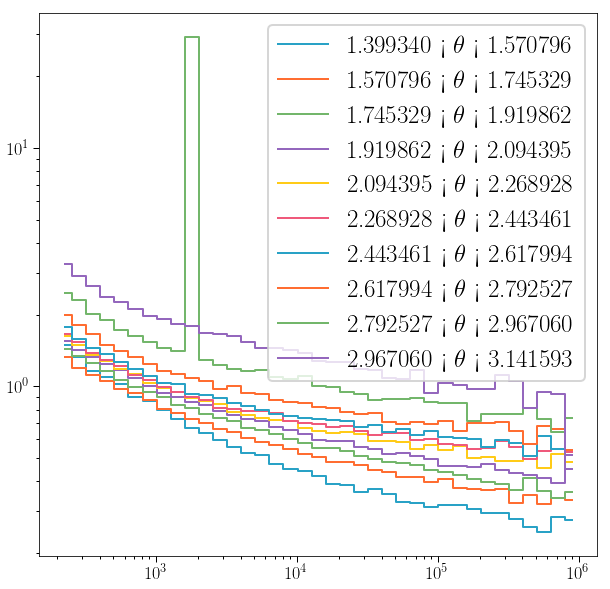

In [215]:
zen_edges  = np.append(np.min(nuZens),np.radians(np.linspace(90,180,10)))
zen_cents  = (zen_edges[1:]+zen_edges[:-1])/2.
zen_widths = zen_edges[1:]+zen_edges[:-1]

med_error = np.zeros((len(zen_cents), len(nue_cents[3:])))

for k in range(len(zen_edges)-1):
    print(k)
    lower_zen = zen_edges[k]
    upper_zen = zen_edges[k+1]
    label_str = r"%f < $\theta$ < %f" % (lower_zen, upper_zen)

    mask = np.logical_and(nuZens > lower_zen, nuZens < upper_zen)

    h = np.histogram2d(log10nuE[mask], opening_angles[mask], bins=[log10e_edges, delta_psi_edges])

    errs_16   = []
    errs_84   = []
    norms     = []
    for j, arr in enumerate(h[0][3:]):

        i0, i1 = get_zeros_outta_there(arr)
        arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
        delta_psi_centers_good = delta_psi_centers[i0:i1]

        dn_dtheta = arr / delta_psi_widths

        f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-3)
    #     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


        def dn_dtheta_interp(x):
            logx = f(np.log10(x))
            return np.power(10, logx)

        def cdf(y, norm):

            i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
            return i[0] / norm

        i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


        print(i[1] / i[0])
        norm = i[0]
        norms.append(norm)

        xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
        yy = [cdf(x, norm) for x in xx]
        spline = dn_dtheta_interp(xx)

        p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
        arr    = np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p)
        median = np.median(arr)
#         err_84 = scoreatpercentile(arr, 86)
#         err_16 = scoreatpercentile(arr, 16)
        med_error[k,j] = median
#         errs_16.append(err_16)
#         errs_84.append(err_84)
        
    plt.step(nue_cents[3:], med_error[k], where="mid", label=label_str)
    
plt.legend()
plt.loglog()
plt.show()

#         plt.step(delta_psi_centers, dn_dtheta / norm)
    #     plt.step(xx,spline / norm)
    #     plt.step(xx,yy)
    # #     plt.semilogx()

    #     plt.axvline(median)

    #     plt.title(nue_cents[j+3])
    #     plt.xlim(1e-3,5)
    #     plt.ylim(0,2)
    #     plt.grid()
    #     plt.show()

1.25977603145e-08
1.31394603318e-08
1.18066046576e-08
1.13956608601e-08
1.47848156744e-08
1.30699857844e-08
1.15158385507e-08
1.29001984004e-08
1.19807782753e-08
1.3429800431e-08
1.37316656965e-08
1.24028891684e-08
1.30419482249e-08
1.08342008313e-08
1.39721150282e-08
1.28068767777e-08
1.43332245236e-08
1.26419652967e-08
1.20081692109e-08
1.41270268617e-08
1.48244703755e-08
1.37415439586e-08
1.38353411292e-08
1.2844286584e-08
1.44231461843e-08
1.21983029235e-08
1.46562724918e-08
1.03532101838e-08
1.19538138274e-08
1.40822387873e-08
1.28497381168e-08
1.25638016551e-08
1.48242128528e-08
1.42199505582e-08
1.06061687659e-08
1.00390867108e-08
1.25814888427e-08
1.48775454458e-08
1.25984418214e-08
1.05163441594e-08
1.19807592535e-08
8.8886838296e-09
1.40311986289e-08
1.19852887421e-08
1.26744793447e-08
1.39366267987e-08
9.88925698029e-09
1.03285896216e-08
1.29721716849e-08
1.27532013644e-08
1.47331771807e-08
1.39578415221e-08
1.44226586515e-08
1.39859544998e-08
1.43555591035e-08
1.30422260406

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1.28809130671e-08
1.31866702327e-08
1.48252584174e-08
1.35916278881e-08
1.27927719736e-08
1.40420742549e-08
1.44605716432e-08
1.48921875398e-08
1.45975094494e-08
1.42250586213e-08
1.15656491113e-08
1.24036334638e-08
1.17934831677e-08
1.13505022172e-08
1.3105743751e-08
1.34916882789e-08
1.47027610962e-08
1.2377066032e-08
1.34770799595e-08
1.29567055121e-08
1.25453221412e-08
1.20032710632e-08
1.43670614349e-08
1.46656270686e-08
1.40824423858e-08
1.40114860216e-08
1.37667293954e-08
1.32639155779e-08
1.3984704042e-08
1.31712698476e-08
1.25745863174e-08
1.29281334717e-08
1.27485235731e-08
1.38244772226e-08
1.02670626547e-08
1.22613473046e-08
1.48083922495e-08
1.11542610944e-08
1.36054723261e-08
1.23463660884e-08
1.42624617532e-08
1.3963271679e-08
1.47185693576e-08
1.18857867127e-08
1.29769212642e-08
1.32239184922e-08
1.43002031562e-08
4.74480773782e-09
1.39173199178e-08
1.43426983187e-08
1.34951346404e-08
1.4781081558e-08
1.31737270787e-08
1.45897110894e-08
1.24966957411e-08
1.39106512431e-

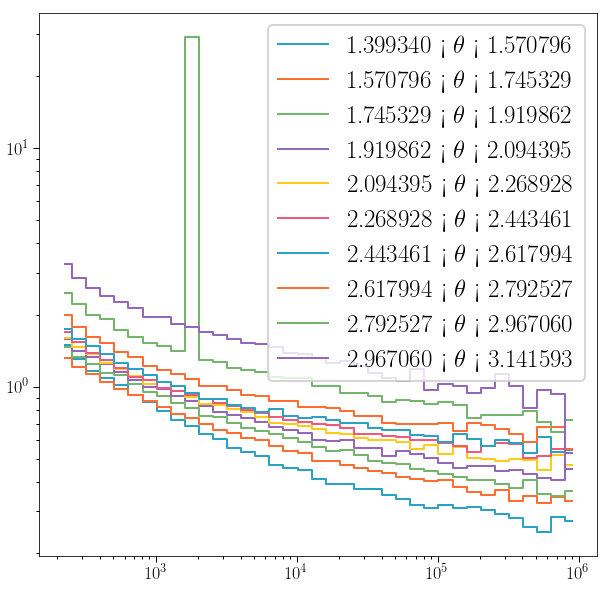

In [213]:
zen_edges  = np.append(np.min(nuZens),np.radians(np.linspace(90,180,10)))
zen_cents  = (zen_edges[1:]+zen_edges[:-1])/2.
zen_widths = zen_edges[1:]+zen_edges[:-1]

med_error = np.zeros((len(zen_cents), len(nue_cents[3:])))

for k in range(len(zen_edges)-1):
    print(k)
    lower_zen = zen_edges[k]
    upper_zen = zen_edges[k+1]
    label_str = r"%f < $\theta$ < %f" % (lower_zen, upper_zen)

    mask = np.logical_and(nuZens > lower_zen, nuZens < upper_zen)

    h = np.histogram2d(log10nuE[mask], opening_angles[mask], bins=[log10e_edges, delta_psi_edges])

    errs_16   = []
    errs_84   = []
    norms     = []
    for j, arr in enumerate(h[0][3:]):

        i0, i1 = get_zeros_outta_there(arr)
        arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
        delta_psi_centers_good = delta_psi_centers[i0:i1]

        dn_dtheta = arr / delta_psi_widths

        f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-3)
    #     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


        def dn_dtheta_interp(x):
            logx = f(np.log10(x))
            return np.power(10, logx)

        def cdf(y, norm):

            i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
            return i[0] / norm

        i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


        print(i[1] / i[0])
        norm = i[0]
        norms.append(norm)

        xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
        yy = [cdf(x, norm) for x in xx]
        spline = dn_dtheta_interp(xx)

        p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
        arr    = np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p)
        median = np.median(arr)
#         err_84 = scoreatpercentile(arr, 86)
#         err_16 = scoreatpercentile(arr, 16)
        med_error[k,j] = median
#         errs_16.append(err_16)
#         errs_84.append(err_84)
        
    plt.step(nue_cents[3:], med_error, where="mid", label=label_str)
    
plt.legend()
plt.loglog()
plt.show()

#         plt.step(delta_psi_centers, dn_dtheta / norm)
    #     plt.step(xx,spline / norm)
    #     plt.step(xx,yy)
    # #     plt.semilogx()

    #     plt.axvline(median)

    #     plt.title(nue_cents[j+3])
    #     plt.xlim(1e-3,5)
    #     plt.ylim(0,2)
    #     plt.grid()
    #     plt.show()

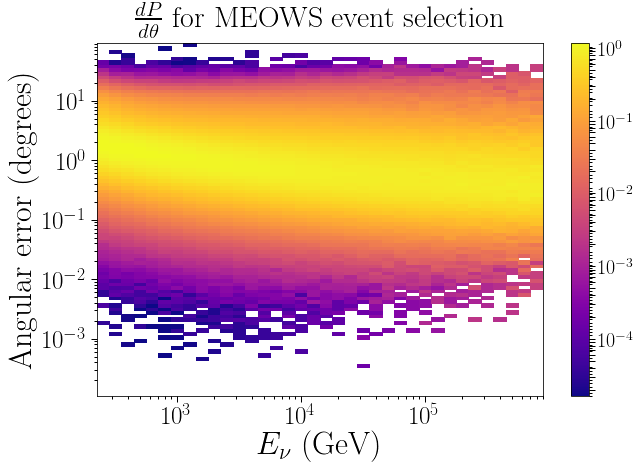

In [159]:
X,Y = np.meshgrid(nue_cents[3:],delta_psi_centers)

fig = plt.figure(figsize=(10,6.5))

hist = (h[0][3:].T / [norms for i in range(100)])
im = plt.pcolor(X, Y, hist, norm=LogNorm())

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel("Angular error (degrees)")
plt.title(r"$\frac{dP}{d\theta}$ for MEOWS event selection", fontsize=30)


cbar = plt.colorbar(im, orientation='vertical',format=LogFormatterMathtext())
cbar.ax.tick_params(labelsize=20) 

plt.tick_params(labelsize=25)


plt.savefig("plots/MEOWS_angular_erros_hm.png", dpi=400, bbox_inches="tight")
plt.show()
# print(np.divide(h[0][3:], norms, axis=0) )

In [208]:
np.savetxt("data/MEOWS_ang_errors.csv", hist, delimiter=",")

In [196]:
def exp(x, lamb):
    return np.exp(-lamb*x)
def lognorm(x, sigma, mu):
    return (1./x)*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power(np.log(x)-mu, 2)/(2*sigma**2))
def lognorm_conv_exp(x, sigma, mu, lamb, scale):
    i = integrate.quad(lambda t: exp(x-t, lamb)*lognorm(t, sigma, mu), 1, 10)
#     assert i[1]/i[0]<1e-7
    return scale * i[0]
def lognorm_conv_exp_arr(xarr, sigma, mu, lamb, scale):
    results = np.zeros(len(xarr))
    for i, x in enumerate(xarr):
        results[i] = lognorm_conv_exp(x, sigma, mu, lamb, scale)
    return results

In [197]:
print(lognorm_conv_exp_arr(np.asarray([1,2]), 1.15, 0.01, 1, 0.45))

[25.21896295  9.277538  ]


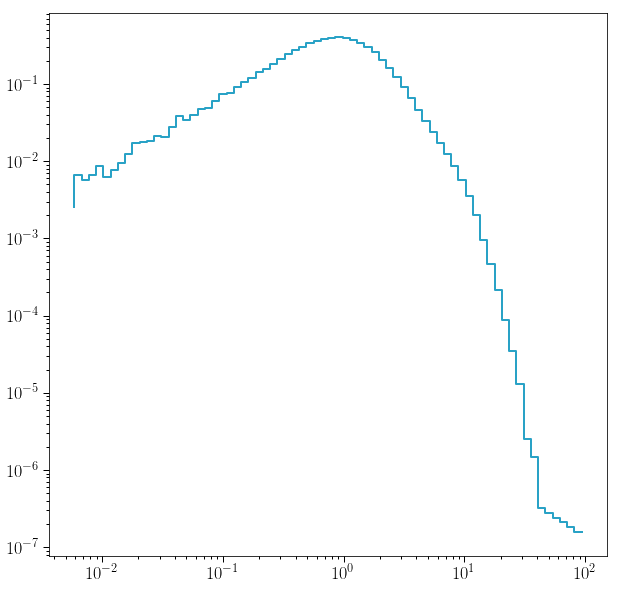

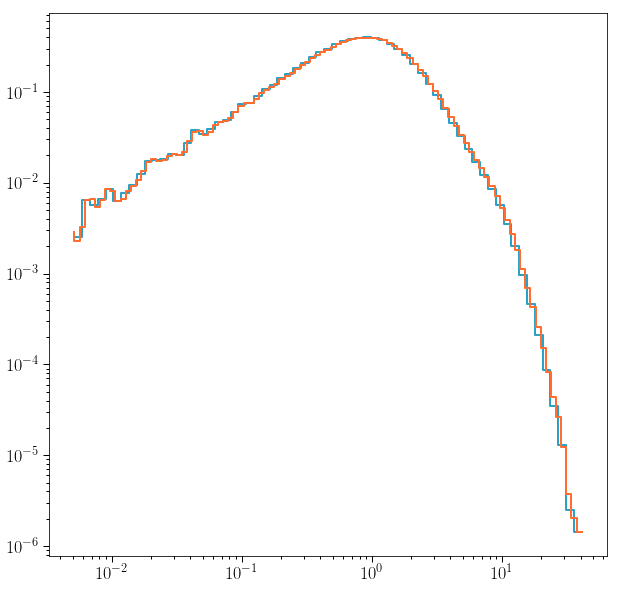

[1.15e+00 1.00e-10 1.00e+00 4.50e-01]


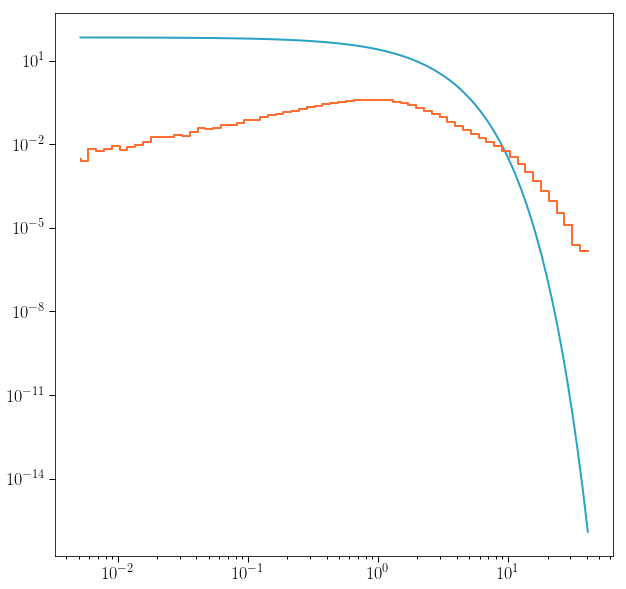

In [195]:
# delta_psi_edges = np.logspace(-4,2,101)
# delta_psi_centers = (delta_psi_edges[1:]+delta_psi_edges[:-1])/2.
# delta_psi_widths  = delta_psi_edges[1:]-delta_psi_edges[:-1]

# dn_dtheta = h[0][4] / delta_psi_widths
# i0, i1 = get_zeros_outta_there(dn_dtheta)
# dn_dtheta = np.concatenate([np.full(i0, dn_dtheta[i0]), dn_dtheta[i0:i1], np.full(len(arr)-i1, 3e-6)])
# delta_psi_widths = delta_psi_widths
# delta_psi_centers = delta_psi_centers

arr = h[0][3]

plt.step(delta_psi_centers[29:], dp_dtheta[29:])
plt.loglog()
plt.show()

i0, i1 = get_zeros_outta_there(arr)
arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
delta_psi_centers_good = delta_psi_centers[i0:i1]

dn_dtheta = arr / delta_psi_widths

f = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


def spline_dn_dtheta(err):
    log10err = np.log10(err)
    return np.power(10, f(log10err))

norm = integrate.quad(lambda x: np.exp(x)*spline_dn_dtheta(np.exp(x)), np.log(delta_psi_centers[i0]), np.log(delta_psi_centers[i1]))

dp_dtheta = dn_dtheta / norm[0]

##### Make sure spline and normalization look goood #####

_ = np.logspace(np.log10(delta_psi_centers[i0]), np.log10(delta_psi_centers[i1-1]), 100) 

plt.step(delta_psi_centers[i0:i1], dp_dtheta[i0:i1])
plt.step(_, [spline_dn_dtheta(err)/norm[0] for err in _])
plt.loglog()
plt.show()



##### Begin fitting #####
popt, pcov = curve_fit(fuckit, 
                       delta_psi_centers[i0:i1-10], 
                       dp_dtheta[i0:i1-10], 
                       p0=[1.15, 0, 1, 0.45],
                       bounds=(0,180)
                      )
print(popt)

plt.plot(_, lognorm_conv_exp_arr(_, *popt))
plt.step(delta_psi_centers[i0:i1], dp_dtheta[i0:i1])
plt.loglog()
plt.show()

In [42]:
for f in [4., 2., 1., 0.5, 0.25]:
    for i in range(100):
        np.load("data/e_d_theta_hist/partial_hists/ch11_m1000_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (f, i))

In [21]:
## # e_cents = (e_bins[:-1]+e_bins[1:])/2
# med_error = []
# norms     = []
# for j, arr in enumerate(h[0][3:]):
    
#     i0, i1 = get_zeros_outta_there(arr)
#     arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
#     delta_psi_centers_good = delta_psi_centers[i0:i1]
    
#     dn_dtheta = arr / np.log(10) / delta_psi_centers
    
#     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-4)
# #     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)
    
    
#     def dn_dtheta_interp(x):
#         logx = f(np.log10(x))
#         return np.power(10, logx)
    
#     def cdf(y, norm):

#         i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
#         return i[0] / norm

#     i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


#     print(i[1] / i[0])
#     norm = i[0]
#     norms.append(norm)
    
#     xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
#     yy = [cdf(x, norm) for x in xx]
#     spline = dn_dtheta_interp(xx)
    
#     p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
#     median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))
#     med_error.append(median)
    
#     plt.step(delta_psi_centers, dn_dtheta / norm)
#     plt.step(xx,spline / norm)
#     plt.step(xx,yy)
# #     plt.semilogx()

#     plt.axvline(median)
    
#     plt.title(nue_cents[j+3])
#     plt.xlim(1e-3,5)
#     plt.ylim(0,2)
#     plt.grid()
#     plt.show()

In [22]:
# p = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
# np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

In [23]:
# sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)

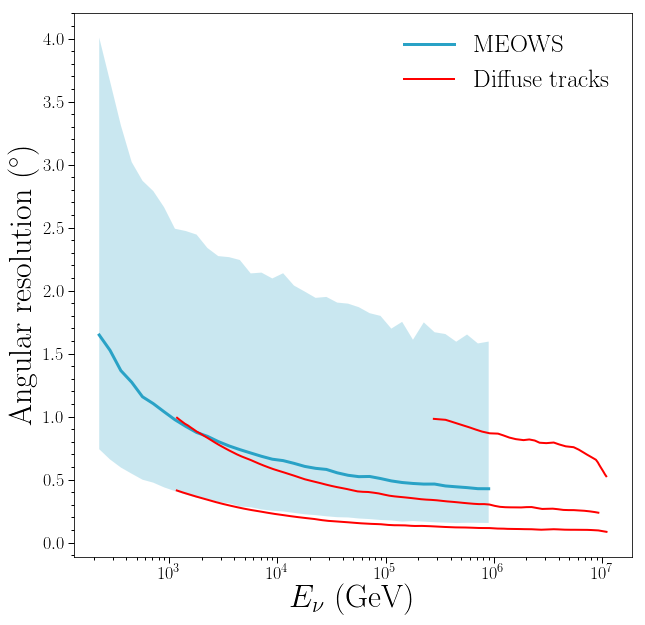

In [182]:
df84 = np.genfromtxt("data/diffuse_tracks_84_resolution.csv", delimiter=",").T
df16 = np.genfromtxt("data/diffuse_tracks_16_resolution.csv", delimiter=",").T
dfm  = np.genfromtxt("data/diffuse_tracks_median_resolution.csv", delimiter=",").T



lw=3

plt.fill_between(nue_cents[3:], errs_16, errs_84, alpha=0.25)
plt.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw)
plt.plot(df84[0], df84[1], color="r")
plt.plot(df16[0], df16[1], color="r")
plt.plot(dfm[0], dfm[1], color="r", label="Diffuse tracks")

plt.semilogx()

plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel(r"Angular resolution ($^\circ$)")
# 
# plt.title("Median angular resolution")
plt.legend(frameon=False)

plt.show()


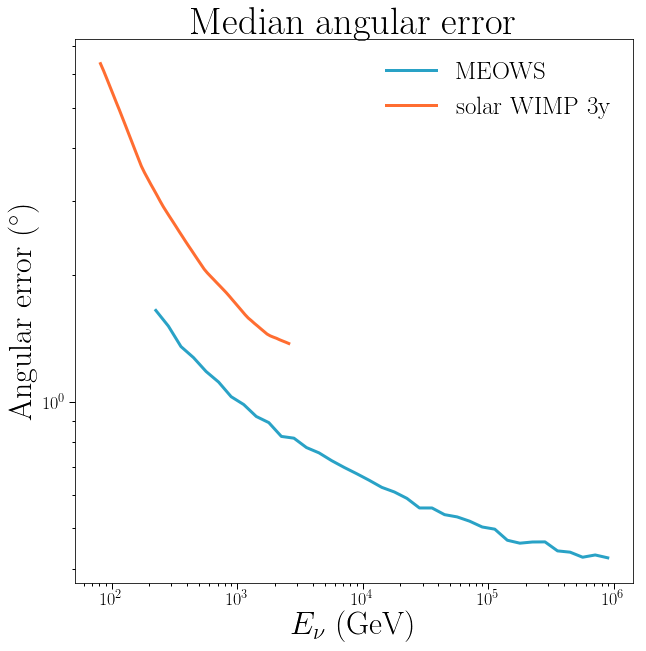

In [49]:
lw=3

_ = np.genfromtxt("/data/user/jlazar/solar_WIMP/data//3y_solar_WIMP_ang_res.csv", delimiter=",").T
old_e   = _[0]
old_res = _[1]

plt.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw)
plt.plot(old_e, old_res, label="solar WIMP 3y", lw=lw)
plt.loglog()

plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel(r"Angular error ($^\circ$)")

plt.title("Median angular error")
plt.legend(frameon=False)

plt.show()


In [27]:
def error_curve(x, a, b, c):
    return a*x**(-b)+c

In [28]:
MEOWS_spline = UnivariateSpline(np.log10(nue_cents[3:]), np.log10(med_error), k=3, )
solar_WIMP_3y_spline = UnivariateSpline(np.log10(old_e), np.log10(old_res), k=3, )

def MEOWS_error(nu_e):
    log10err = MEOWS_spline(np.log10(nu_e))
    return 10**log10err

def sw_3y_error(nu_e):
    log10err = solar_WIMP_3y_spline(np.log10(nu_e))
    return 10**log10err

def ratio(nu_e):
    return np.divide(sw_3y_error(nu_e), MEOWS_error(nu_e))

In [19]:
np.save("data/MEOWS_median_error_spline.npy", MEOWS_spline, allow_pickle=True)

AttributeError: 'module' object has no attribute 'set_xlabel'

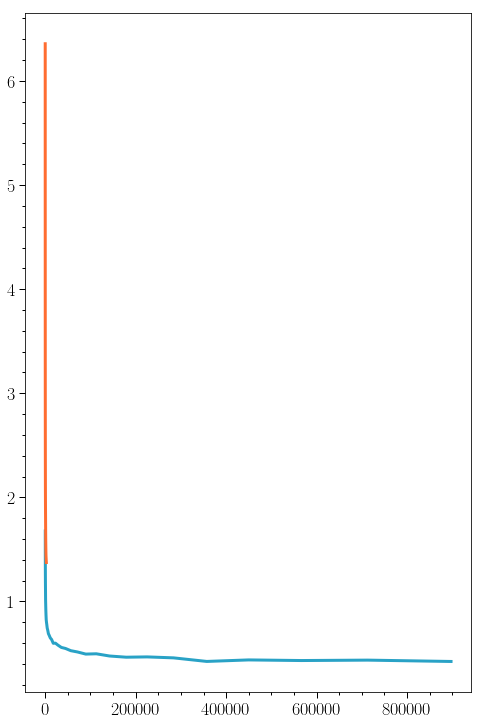

In [196]:
lw=3

fig = plt.figure(figsize=(8,12.5))
# gs = gridspec.GridSpec (2, 1,height_ratios=[1,1])
# (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

#### Top plot ####

plt.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw)
plt.plot(old_e, old_res, label="3y sample", lw=lw)
# plt.plot(np.logspace(np.log10(200),4,1000), MEOWS_error(np.logspace(np.log10(200),4,1000)), 
#          label="MEOWS spline", lw=lw, linestyle=ls, color="r")
# ax1.plot(np.logspace(np.log10(200),4,1000), sw_3y_error(np.logspace(np.log10(200),4,1000)),
#          label="3y sample spline", lw=lw, linestyle=ls)

plt.set_xlabel(r"$E_{\nu}$ (GeV)")
plt.set_ylabel(r"Median angular error (degrees)", fontsize=25)

plt.legend(frameon=False)
plt.show()

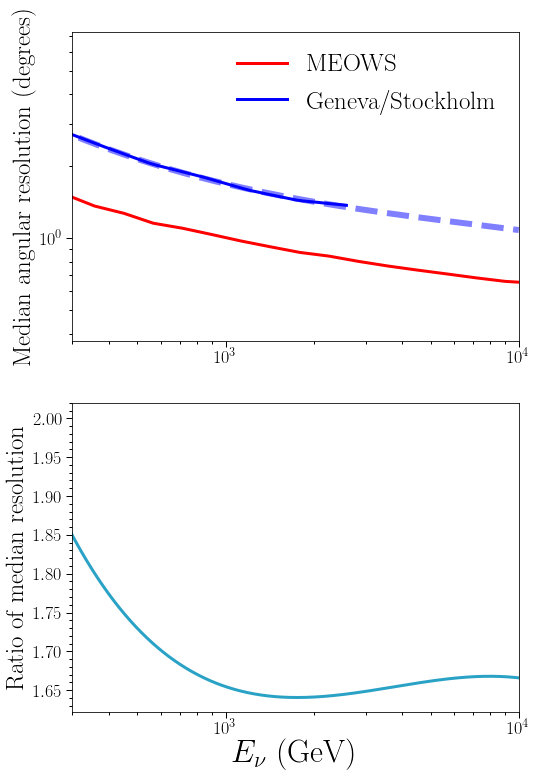

In [185]:
lw=3
ls="--"

fig = plt.figure(figsize=(8,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[1,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

#### Top plot ####
ax1.plot(np.logspace(np.log10(200),4,1000), sw_3y_error(np.logspace(np.log10(200),4,1000)),
         lw=6, alpha=0.5, linestyle=ls, color="b")
ax1.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw, color="r")
ax1.plot(old_e, old_res, label="Geneva/Stockholm", lw=lw, color="b")
# ax1.plot(np.logspace(np.log10(200),4,1000), MEOWS_error(np.logspace(np.log10(200),4,1000)), 
#          label="MEOWS spline", lw=lw, linestyle=ls, color="r")


# ax1.set_xlabel(r"$E_{\nu}$ (GeV)")
ax1.set_ylabel(r"Median angular resolution (degrees)", fontsize=25)

ax1.legend(frameon=False)

ax1.loglog()
ax1.set_xlim(300,10000)

#### Bottom plot ####

ax2.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),
         lw=lw)

ax2.set_ylabel("Ratio of median resolution", fontsize=25)
ax2.set_xlabel(r"$E_{\nu}$ (GeV)")
# ax2.set_title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

ax2.semilogx()
ax2.set_xlim(300,10000)

plt.savefig("plots/median_error_comparison_w_ratio.png", dpi=400, bbox_inches="tight")

plt.show()

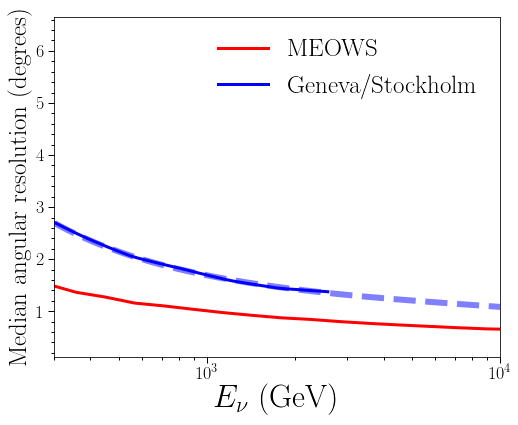

In [189]:
fig = plt.figure(figsize=(8,6.25))
#### Top plot ####
plt.plot(np.logspace(np.log10(200),4,1000), sw_3y_error(np.logspace(np.log10(200),4,1000)),
         lw=6, alpha=0.5, linestyle=ls, color="b", label="")
plt.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw, color="r")
plt.plot(old_e, old_res, label="Geneva/Stockholm", lw=lw, color="b")
# ax1.plot(np.logspace(np.log10(200),4,1000), MEOWS_error(np.logspace(np.log10(200),4,1000)), 
#          label="MEOWS spline", lw=lw, linestyle=ls, color="r")


# ax1.set_xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel(r"Median angular resolution (degrees)", fontsize=25)
plt.xlabel(r"$E_{\nu}$ (GeV)")

plt.legend(frameon=False)

plt.semilogx()
plt.xlim(300,10000)
plt.savefig("plots/median_error_comparison.png", dpi=400, bbox_inches="tight")
plt.show()

In [ ]:
np.min(ratio(np.logspace(np.log10(200),4,1000)))

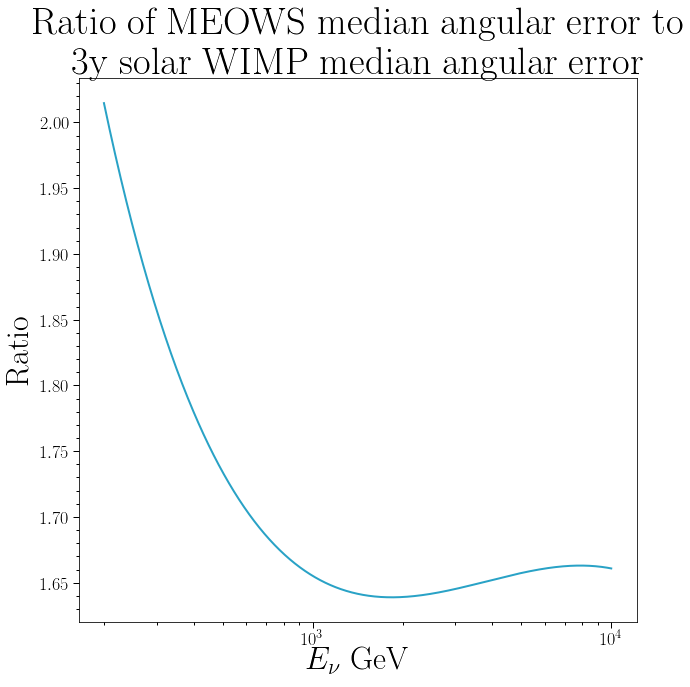

In [20]:
plt.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),)

plt.ylabel("Ratio")
plt.xlabel(r"$E_{\nu}$ GeV")
plt.title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

plt.semilogx()

plt.show()

In [12]:
# # arr = np.full(len(log10nuE), np.nan)
# np.random.seed(400)

# gen_op_ang1 = np.multiply(ratio(np.power(10,log10nuE)), 
#                             np.radians(opening_angles), 
#                             where=~(log10nuE>4), 
# #                             out=np.full(len(log10nuE), np.nan)
#                           )
# gen_az1 = np.random.rand(len(gen_op_ang1))*2*np.pi
# print(gen_op_ang1)
# r_az1, r_zen1 = rotate_coords(nuAzs, nuZens, gen_az1, gen_op_ang1)
# print(opening_angle(r_zen1, r_az1, nuZens, nuAzs))
# arr1 = np.recarray(len(r_az1), 
#                   dtype=[("rescaled_reco_az", float),
#                          ("rescaled_reco_zen", float)]
#                  )
# arr1["rescaled_reco_az"][:] = r_az1
# arr1["rescaled_reco_zen"][:] = r_zen1

# np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/rescaled_reco_angles.npy", arr)

In [13]:
# # arr = np.full(len(log10nuE), np.nan)
# np.random.seed(400)

# gen_op_ang2 = np.multiply(ratio(np.power(10,log10nuE)), 
#                             np.radians(opening_angles), 
#                             where=~(log10nuE>4), 
#                             out=np.random.rand(len(log10nuE))*np.pi
#                         )
# gen_az2 = np.random.rand(len(gen_op_ang2))*2*np.pi
# print(gen_op_ang2)
# r_az2, r_zen2 = rotate_coords(nuAzs, nuZens, gen_az2, gen_op_ang2)
# print(opening_angle(r_zen2, r_az2, nuZens, nuAzs))
# arr2 = np.recarray(len(r_az), 
#                   dtype=[("rescaled_reco_az", float),
#                          ("rescaled_reco_zen", float)]
#                  )
# arr2["rescaled_reco_az"][:] = r_az2
# arr2["rescaled_reco_zen"][:] = r_zen2

# np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/rescaled_reco_angles_rand.npy", arr)

In [14]:
# np.load("/Users/jlazar/Documents/IceCube/solar_WIMP/data/mc_dn_dz/ch5_m4000_mc_dn_dz.npy")[np.where(gen_op_ang1==gen_op_ang2)[0]]

In [69]:
import gen_rescale_az_zen as gaz

In [72]:
new_az, new_zen = gaz.gen_newzen_az(4)

In [71]:
gaz.opening_angle(gaz.nu_zen, gaz.nu_az, gaz.reco_zen, gaz.reco_az)

array([0.02736594, 0.04763367, 0.00789867, ..., 0.01184808, 0.00750605,
       0.02014435])

In [73]:
gaz.opening_angle(gaz.nu_zen, gaz.nu_az, new_zen, new_az)

array([0.10946378, 0.19053466, 1.86406559, ..., 0.04739232, 0.03002419,
       3.02784773])

In [96]:
def lognorm(x, sigma, mu):
    return (1./x)*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power(np.log(x)-mu, 2)/(2*sigma**2))
def exp(x, lamb):
    return np.exp(-lamb*x)
def lognorm_cdf(x, sigma, mu):
    return integrate.quad(lognorm, 0., float(x), args=(sigma, mu))
def exp_cdf(x, lamb):
    return 1-np.exp(-lamb*x)

In [97]:
lognorm_cdf(100., 0.25, 0.)

(1.0, 2.0179993522991163e-12)

In [98]:
def min_x(sigma, mu, lamb, inc=0.9991):
    func  = lambda x: lognorm_cdf(x, sigma, mu)[0] - inc
    x_in = 3*mu+1
    x_ln = broyden1(func, x_in)
    func  = lambda x: exp_cdf(x, lamb) - inc
    x_exp = broyden1(func, 2)
    return max([x_ln, x_exp])

In [132]:
sigma = 0.25
mu = 0
lamb = 0.5
def ln_conv_exp_fft(sigma, mu, lamb):
    mx = min_x(sigma, mu, lamb)
    xx = np.linspace(0.001, mx, 100)
    fft_ln  = fft(lognorm(xx, sigma, mu))
    fft_exp = fft(exp(xx, lamb))
    
    conv = ifft(fft_ln * fft_exp)
    assert np.max(np.imag(conv)) < 1e-10
    
    return xx, np.real(conv)

def ln_conv_exp(x, sigma, mu, lamb, scale):
    convx = lambda t: integrate.quad(lambda tau: lognorm(tau, sigma, mu) * exp(tau-t, lamb), 0, np.inf)[0]
    return scale * convx(x)
    
    

def lalala(x, sigma, mu, lamb, scale):
    f = UnivariateSpline(*ln_conv_exp(sigma, mu, lamb), k=5, s=1e-3)
    return scale*f(x)


# popt_conv, popt_gamma  = curve_fit(lalala, delta_psi_centers, dp_dtheta, p0=[1, 0.5, 0.5, 1])
# plt.plot()

In [125]:
sigma = 0.25
mu = 0
lamb = 2
mx = min_x(sigma, mu, lamb)
print(exp_cdf(mx, lamb))
print(lognorm_cdf(mx, sigma, mu)[0])

0.9990997060304565
0.999999739419


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


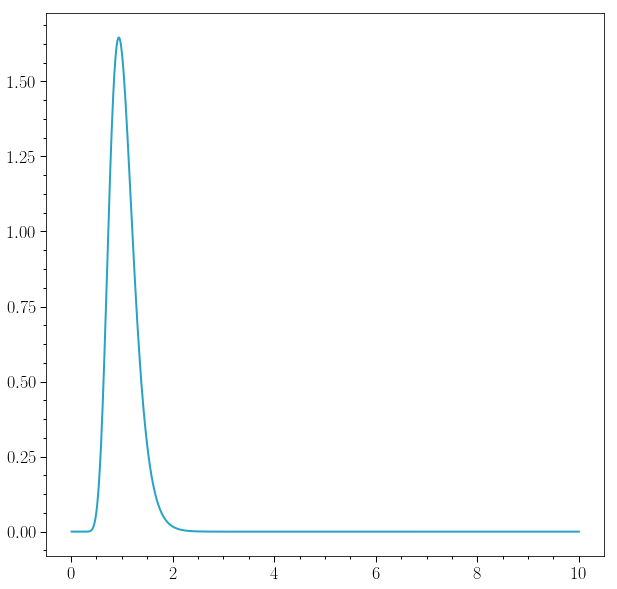

In [126]:
xx = np.linspace(0,10,1000)
plt.plot(xx, lognorm(xx, sigma, mu))

In [133]:
ln_conv_exp(1, 1, 1, 2, 5)

2.353390897472953

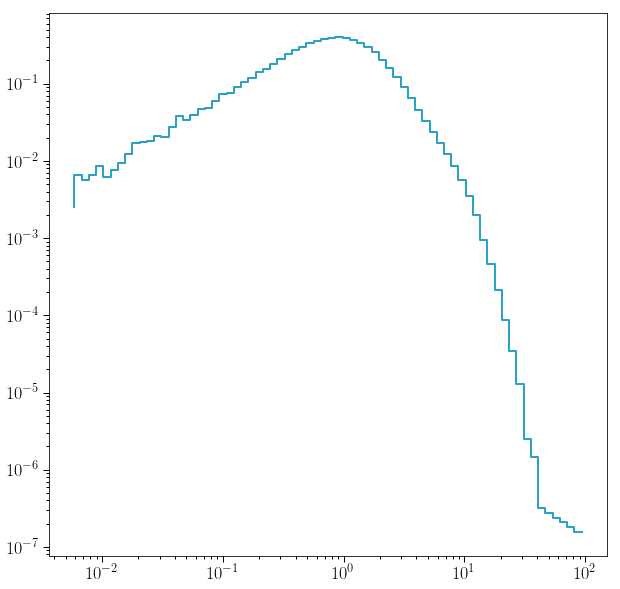

[1.07407681e-04 1.23320518e-04 1.41590899e-04 1.62568104e-04
 1.86653157e-04 2.14306498e-04 2.46056782e-04 2.82510986e-04
 3.24366011e-04 3.72422011e-04 4.27597680e-04 4.90947825e-04
 5.63683523e-04 6.47195278e-04 7.43079603e-04 8.53169537e-04
 9.79569694e-04 1.12469649e-03 1.29132435e-03 1.48263873e-03
 1.70229703e-03 1.95449849e-03 2.24406452e-03 2.57653081e-03
 2.95825318e-03 3.39652910e-03 3.89973719e-03 4.47749738e-03
 5.14085483e-03 5.90249109e-03 6.77696652e-03 7.78099866e-03
 8.93378179e-03 1.02573539e-02 1.17770180e-02 1.35218259e-02
 1.55251334e-02 1.78252381e-02 2.04661117e-02 2.34982403e-02
 2.69795897e-02 3.09767136e-02 3.55660259e-02 4.08352614e-02
 4.68851533e-02 5.38313585e-02 6.18066693e-02 7.09635512e-02
 8.14770582e-02 9.35481795e-02 1.07407681e-01 1.23320518e-01
 1.41590899e-01 1.62568104e-01 1.86653157e-01 2.14306498e-01
 2.46056782e-01 2.82510986e-01 3.24366011e-01 3.72422011e-01
 4.27597680e-01 4.90947825e-01 5.63683523e-01 6.47195278e-01
 7.43079603e-01 8.531695

TypeError: only size-1 arrays can be converted to Python scalars

In [160]:
arr = h[0][3]

plt.step(delta_psi_centers[29:], dp_dtheta[29:])
plt.loglog()
plt.show()

i0, i1 = get_zeros_outta_there(arr)
arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
delta_psi_centers_good = delta_psi_centers[i0:i1]

dn_dtheta = arr / delta_psi_widths

f = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


norm = norms[0]

xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
# yy = [cdf(x, norm) for x in xx]
spline = dn_dtheta_interp(xx)

# Find median of distribution
p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

dp_dtheta = dn_dtheta / norm

print(delta_psi_centers)

popt_logn, pcov_logn   = curve_fit(lognorm, delta_psi_centers,dp_dtheta, p0=[1,1])
print(popt_logn)
popt_conv, pcov_conv  = curve_fit(ln_conv_exp, delta_psi_centers[29:], dp_dtheta[29:], p0=[1.15, 0.01,1,0.45])
# popt_conv, pcov_conv  = curve_fit(lalala, delta_psi_centers, dp_dtheta, p0=[1.15, 0.01,1,0.45])
print(popt_conv)
    
plt.step(delta_psi_centers, dp_dtheta, label="data")
plt.plot(delta_psi_centers, lalala(delta_psi_centers,*popt_conv), label='conv. fit')
# plt.plot(delta_psi_centers, lognorm(delta_psi_centers,*popt_logn), label='lognorm fit')
# plt.plot(delta_psi_centers, lalala(delta_psi_centers,.18620905, -0.07053734,  1.08848316,  0.40290718))

# plt.plot(delta_psi_centers,gamma.pdf(delta_psi_centers,*popt_gamma), label='gamma fit')


plt.legend()

plt.title(nue_cents[4])
# plt.xlim(1e-4,20)
# plt.ylim(0.01,2)
plt.loglog()
plt.grid()
plt.show()

In [ ]:
plt.plot(np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[0][0])
plt.semilogy()

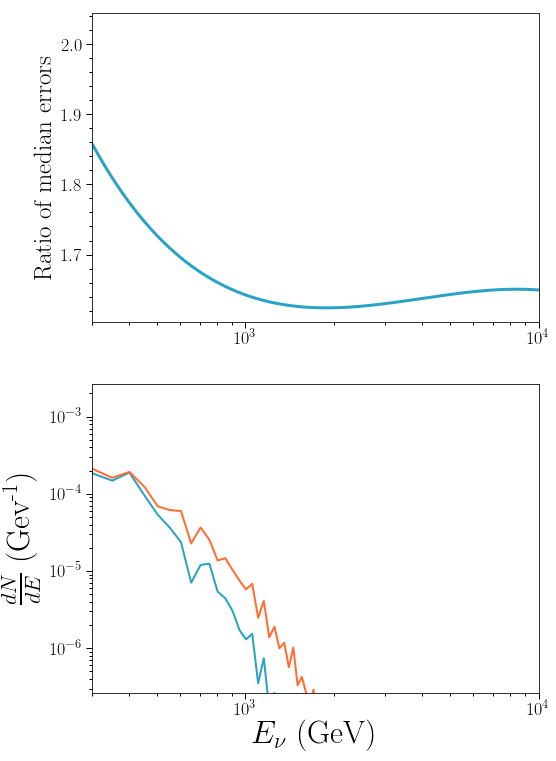

In [35]:
lw=3
ls="--"

nu_flux = np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[0][0]/10000
nu_bar_flux = np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[1][0]/10000
ee = np.linspace(0,10000, len(nu_flux))

fig = plt.figure(figsize=(8,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[1,1])
(ax2, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

#### Top plot ####

ax2.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),
         lw=lw)

ax2.set_ylabel("Ratio of median errors", fontsize=25)
# ax2.set_xlabel(r"$E_{\nu}$ (GeV)")
# ax2.set_title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

ax2.semilogx()
ax2.set_xlim(300,10000)

#### Bottom plot ####

ax1.set_xlabel(r"$E_{\nu}$ (GeV)")

ax1.plot(ee, nu_flux, label=r"$\nu_{\mu}$")
ax1.plot(ee, nu_bar_flux, label=r"bar{\nu}_{\mu}$")

ax1.loglog()
ax1.set_xlim(300,10000)
ax1.set_xlabel(r"$E_{\nu}$ (GeV)")

ax1.set_ylabel(r"$\frac{dN}{dE}$ (Gev\textsuperscript{-1})")
ax1.set_ylim(np.max(nu_flux)/10000, np.max(nu_flux))


plt.savefig("plots/median_error_and_dN_dE.png", dpi=400, bbox_inches="tight")

plt.show()

In [28]:
spl = np.load("data/MEOWS_median_error_spline.npy").item()

In [33]:
10**spl(np.log10(500))

1.2456748467931023

In [31]:
MEOWS_spline(500)

array(-1125486.31435334)

In [31]:
_ = np.asarray([[1,0],[0,0]])
len(_[np.nonzero(_)])

1

In [37]:
opening_angle(np.asarray([2.47950836, 1.76632375]), 
              np.asarray([3.77446789, 1.49110076]), 
              np.asarray([2.5028512,  1.71055966]), 
              np.asarray([3.79805989, 1.46944413]),
             )

array([0.02736595, 0.05971144])

In [38]:
opening_angle(np.asarray([2.53899498, 1.65406756]), 
              np.asarray([3.86876556, 1.36355494]), 
              np.asarray([2.5028512,  1.71055966]), 
              np.asarray([3.79805989, 1.46944413])
             )

array([0.05473188, 0.1194229 ])

In [173]:
np.load("data/")

50.0